# Robustness Checks (0.6/0.2/0.2 split)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Ensure plot qualities 
plt.rcParams['figure.figsize'] = (12,6)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Adjust DPI for high-resolution figures

In [3]:
# Load data
data_path = "/Users/alexzheng/Developer/GitHub/EC331-project/EMH/Data/Bitcoin_data_2024_w_TI_n_Macro.csv"
data = pd.read_csv(data_path, index_col=0, parse_dates=True)

# Use only the "Returns%" column for ARIMA modelling
returns = data['Returns%']

In [4]:
# Train-val-test split 
train_ratio = 0.6
val_ratio = 0.2

train_index = int(len(returns) * train_ratio)
val_index = train_index + int(len(returns) * val_ratio)

train_returns = returns.iloc[:train_index]
val_returns = returns.iloc[train_index:val_index]
test_returns = returns.iloc[val_index:]

print("Train returns shape:", train_returns.shape)
print("Validation returns shape:", val_returns.shape)
print("Test returns shape:", test_returns.shape)

Train returns shape: (305648,)
Validation returns shape: (101882,)
Test returns shape: (101884,)


In [5]:
# # Augmented Dickey-Fuller (ADF)
# result = adfuller(train_returns)
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

In [6]:
# # ACF and PACF Plots
# plt.subplot(121)
# plot_acf(train_returns, lags=30, ax=plt.gca())
# plt.subplot(122)
# plot_pacf(train_returns, lags=30, ax=plt.gca())
# plt.show()

In [7]:
# # Use `auto_arima` to select the optimal order with the lowest AIC 
# auto_arima_model = pm.auto_arima(train_returns, 
#                            seasonal=False,  
#                            trace=True, 
#                            error_action='ignore', 
#                            suppress_warnings=True,
#                            stepwise=True)
# print(auto_arima_model.summary())

In [8]:
# Fit ARIMA model on training returns
order = (1, 0, 2)  
arima_model = ARIMA(train_returns, order=order, trend='n') # trend='n' -> deactivate constant term due to its insignificance
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Returns%   No. Observations:               305648
Model:                 ARIMA(1, 0, 2)   Log Likelihood              343103.510
Date:                Tue, 15 Apr 2025   AIC                        -686199.019
Time:                        23:17:30   BIC                        -686156.499
Sample:                             0   HQIC                       -686186.731
                             - 305648                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5006      0.107     -4.689      0.000      -0.710      -0.291
ma.L1          0.4790      0.107      4.489      0.000       0.270       0.688
ma.L2         -0.0150      0.002     -7.013      0.0

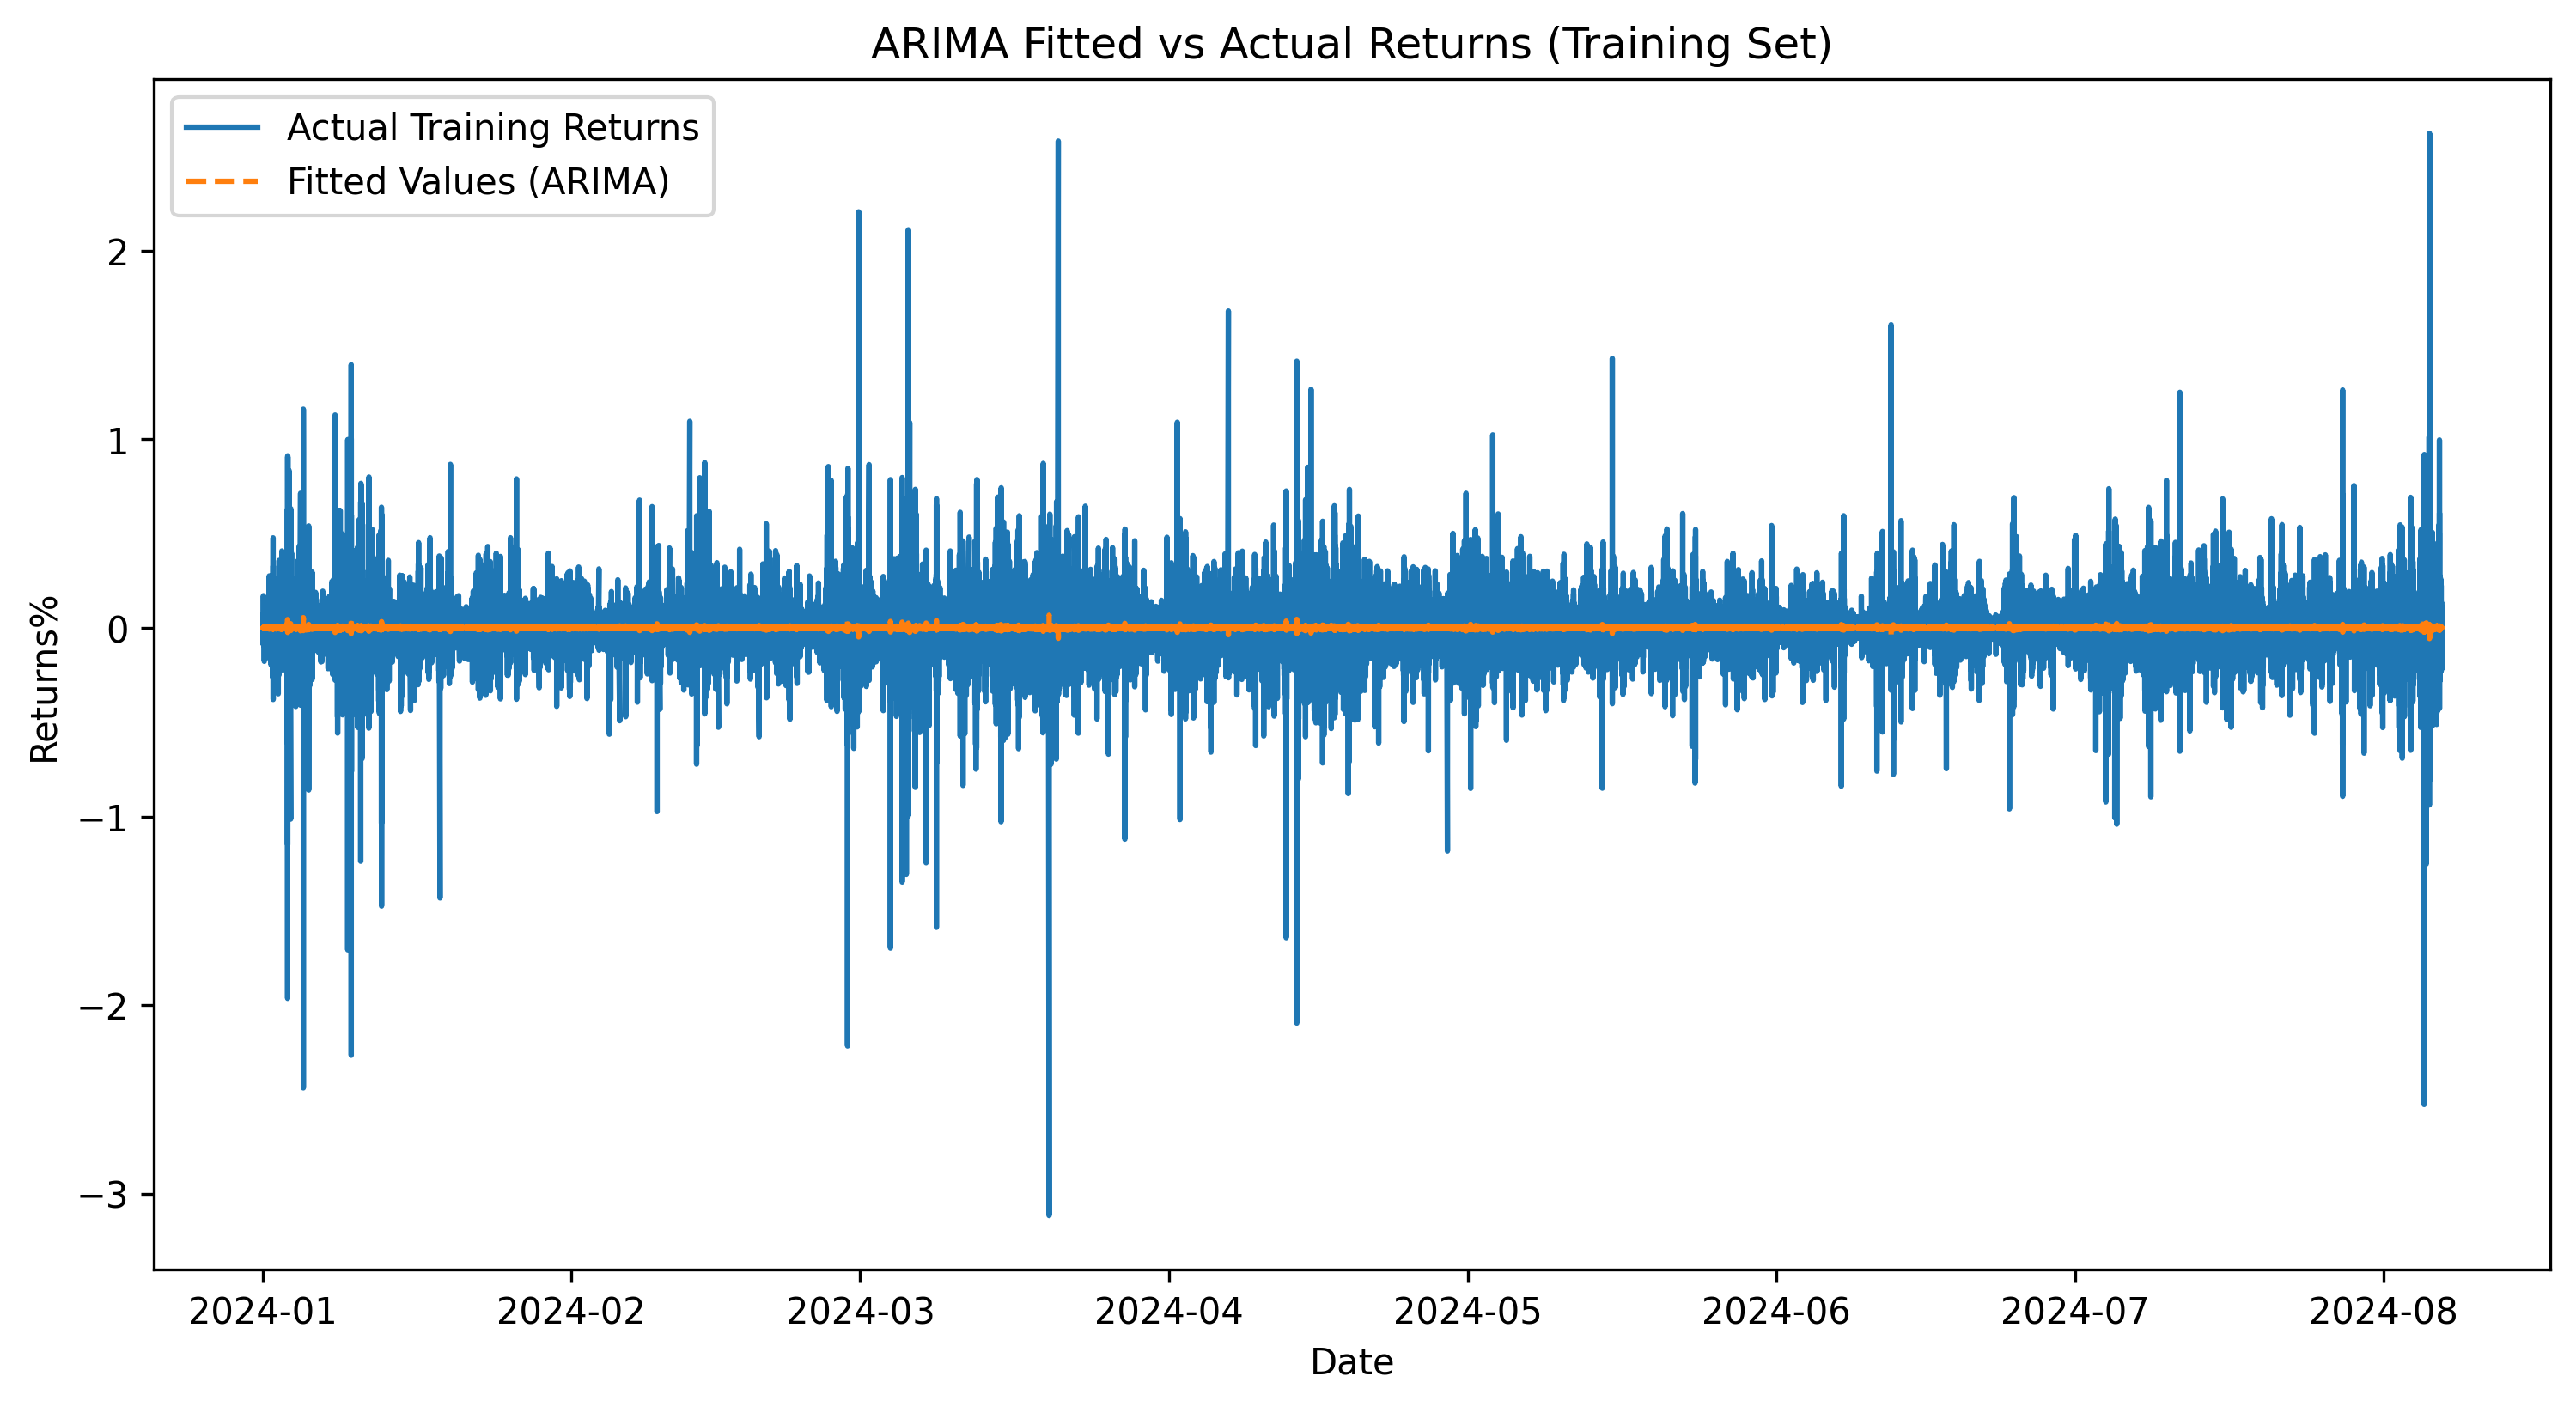

In [9]:
# Inspect fitted values vs actuals on training set
fitted_train = arima_fit.fittedvalues

plt.plot(train_returns.index, train_returns, label='Actual Training Returns')
plt.plot(train_returns.index, fitted_train, label='Fitted Values (ARIMA)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Returns%')
plt.title('ARIMA Fitted vs Actual Returns (Training Set)')
plt.legend()
plt.show()

In [10]:
# Forecasting on the validation set
forecast_val = arima_fit.forecast(steps=len(val_returns))

# For forecasting on the test set, update the model with training + validation data
combined_train_val = returns.iloc[:val_index]
arima_model_updated = ARIMA(combined_train_val, order=order)
arima_fit_updated = arima_model_updated.fit()
forecast_test = arima_fit_updated.forecast(steps=len(test_returns))

In [11]:
# Evaluation function
def evaluate_forecast(actual, predicted, label=""):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")
    
print("Validation Forecast Performance:")
evaluate_forecast(val_returns, forecast_val, label="Validation")

print("\nTest Forecast Performance:")
evaluate_forecast(test_returns, forecast_test, label="Test")

Validation Forecast Performance:
Validation MAE: 0.0424
Validation RMSE: 0.0680

Test Forecast Performance:
Test MAE: 0.0468
Test RMSE: 0.0731


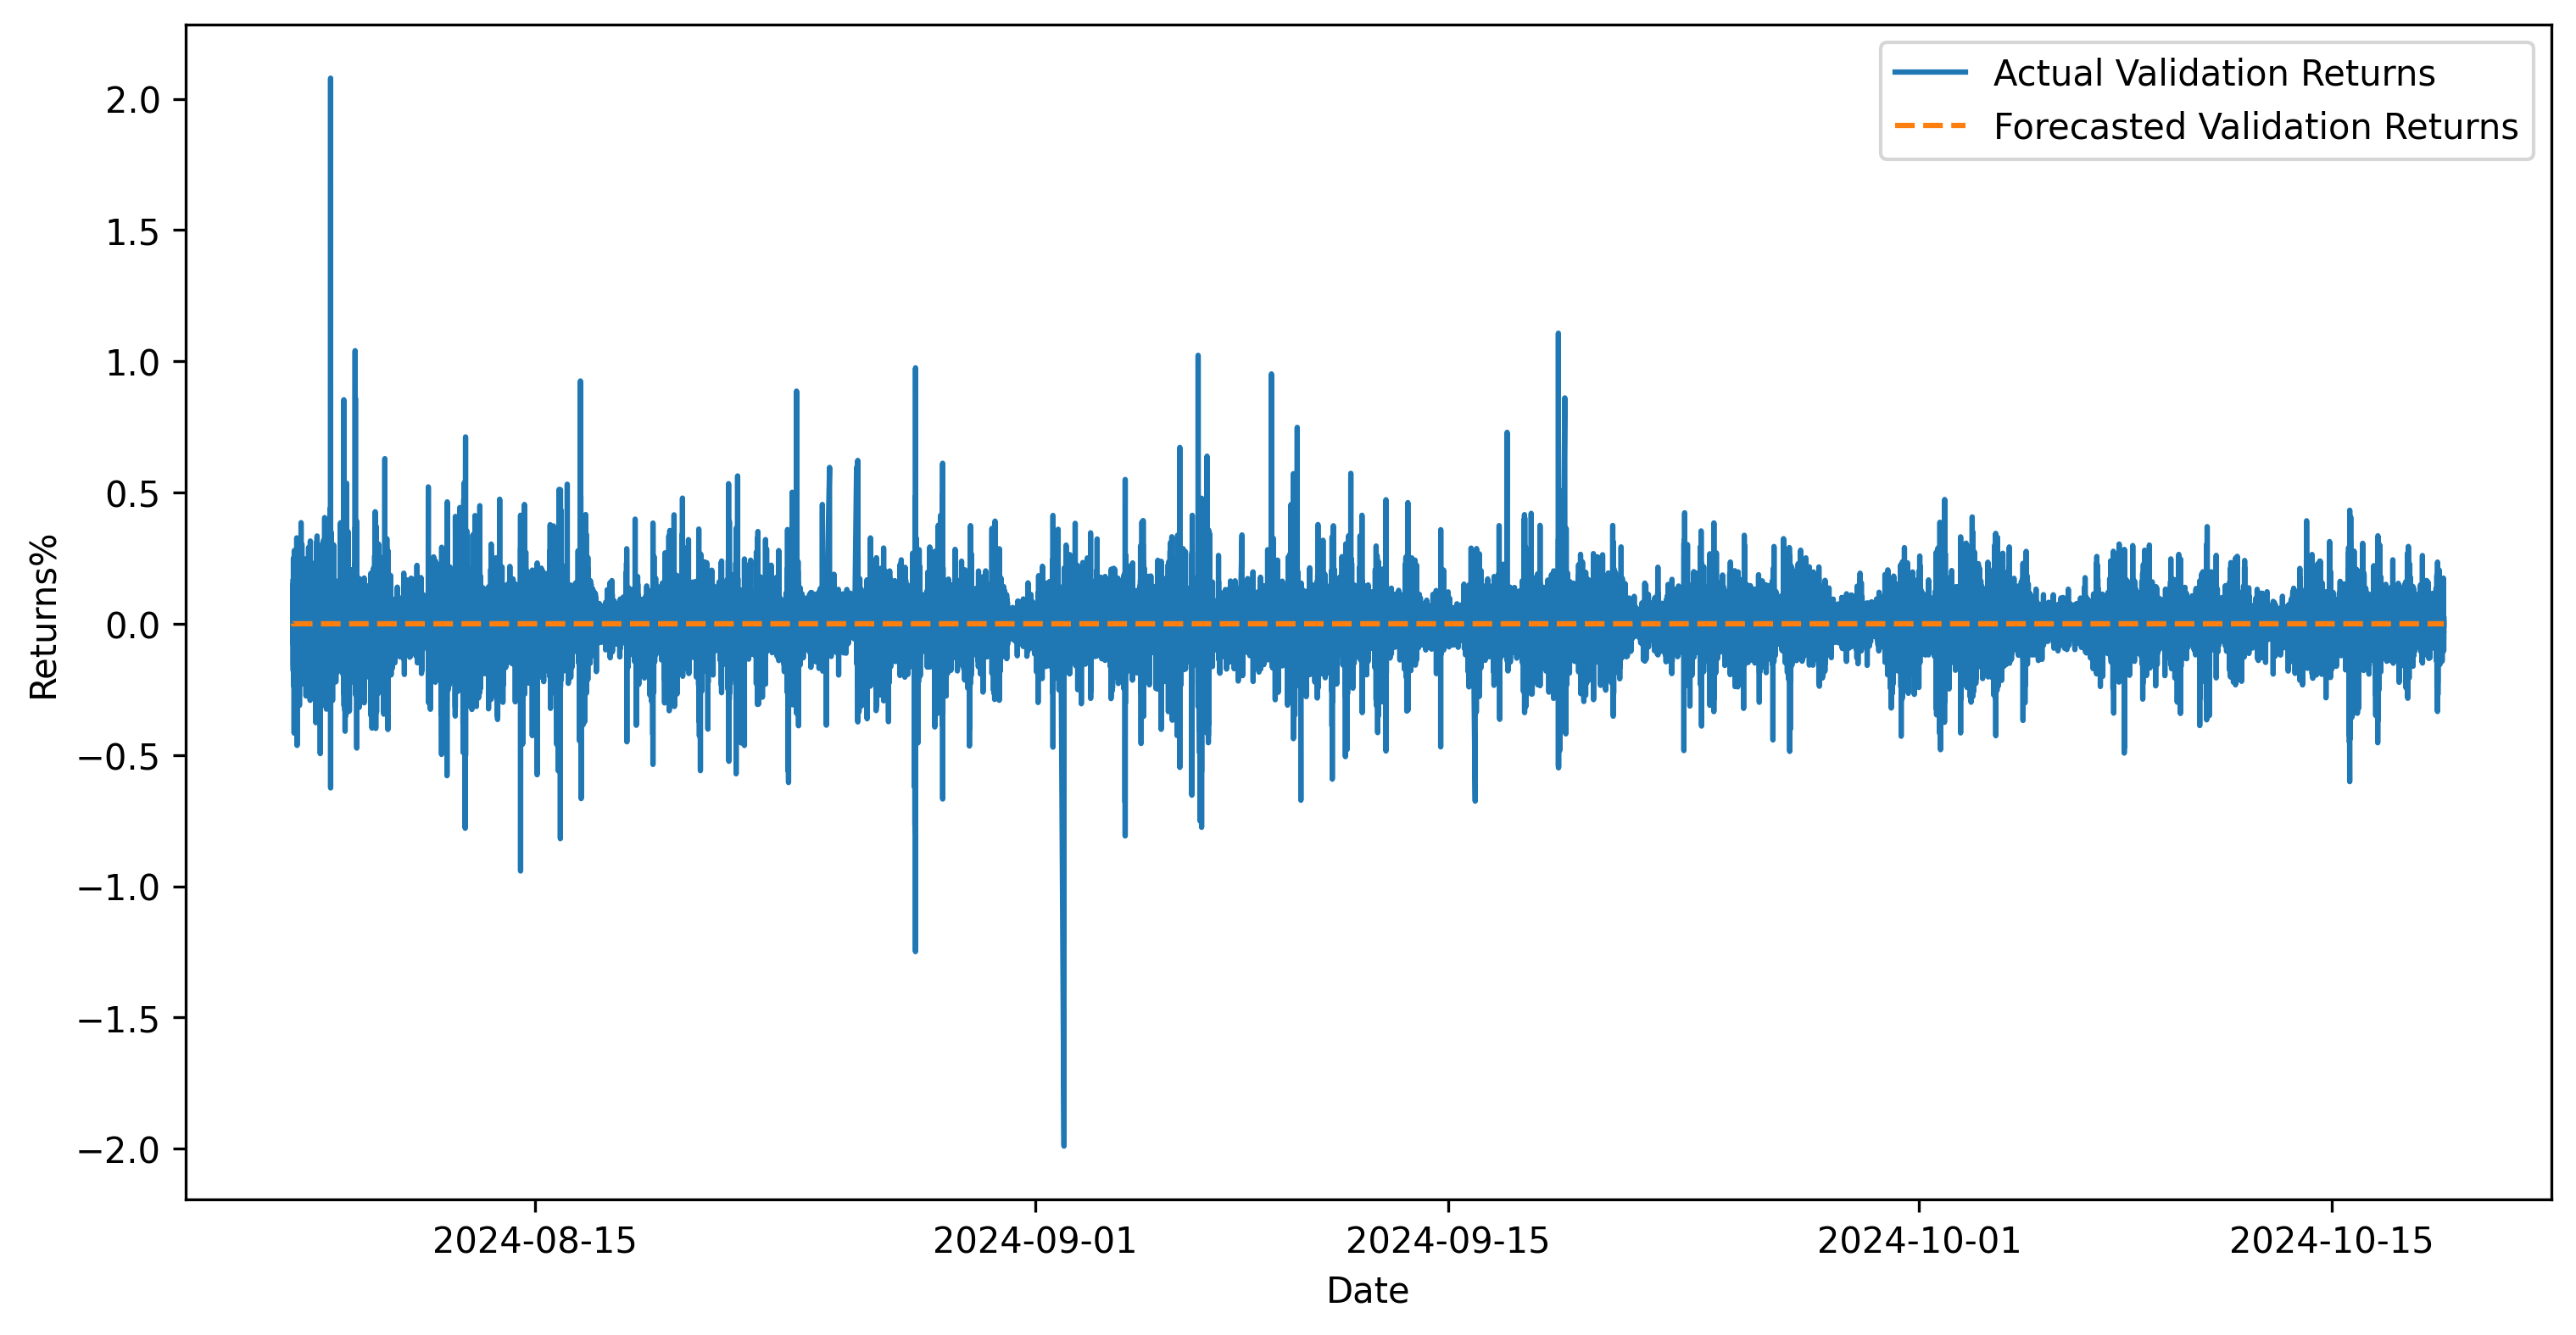

In [12]:
# Plot actual vs forecasted returns for the validation set
plt.plot(val_returns.index, val_returns, label='Actual Validation Returns')
plt.plot(val_returns.index, forecast_val, label='Forecasted Validation Returns', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Returns%')
# plt.title('ARIMA Forecast vs Actual Returns (Validation Set)')
plt.legend()
# plt.grid(True)
plt.show()

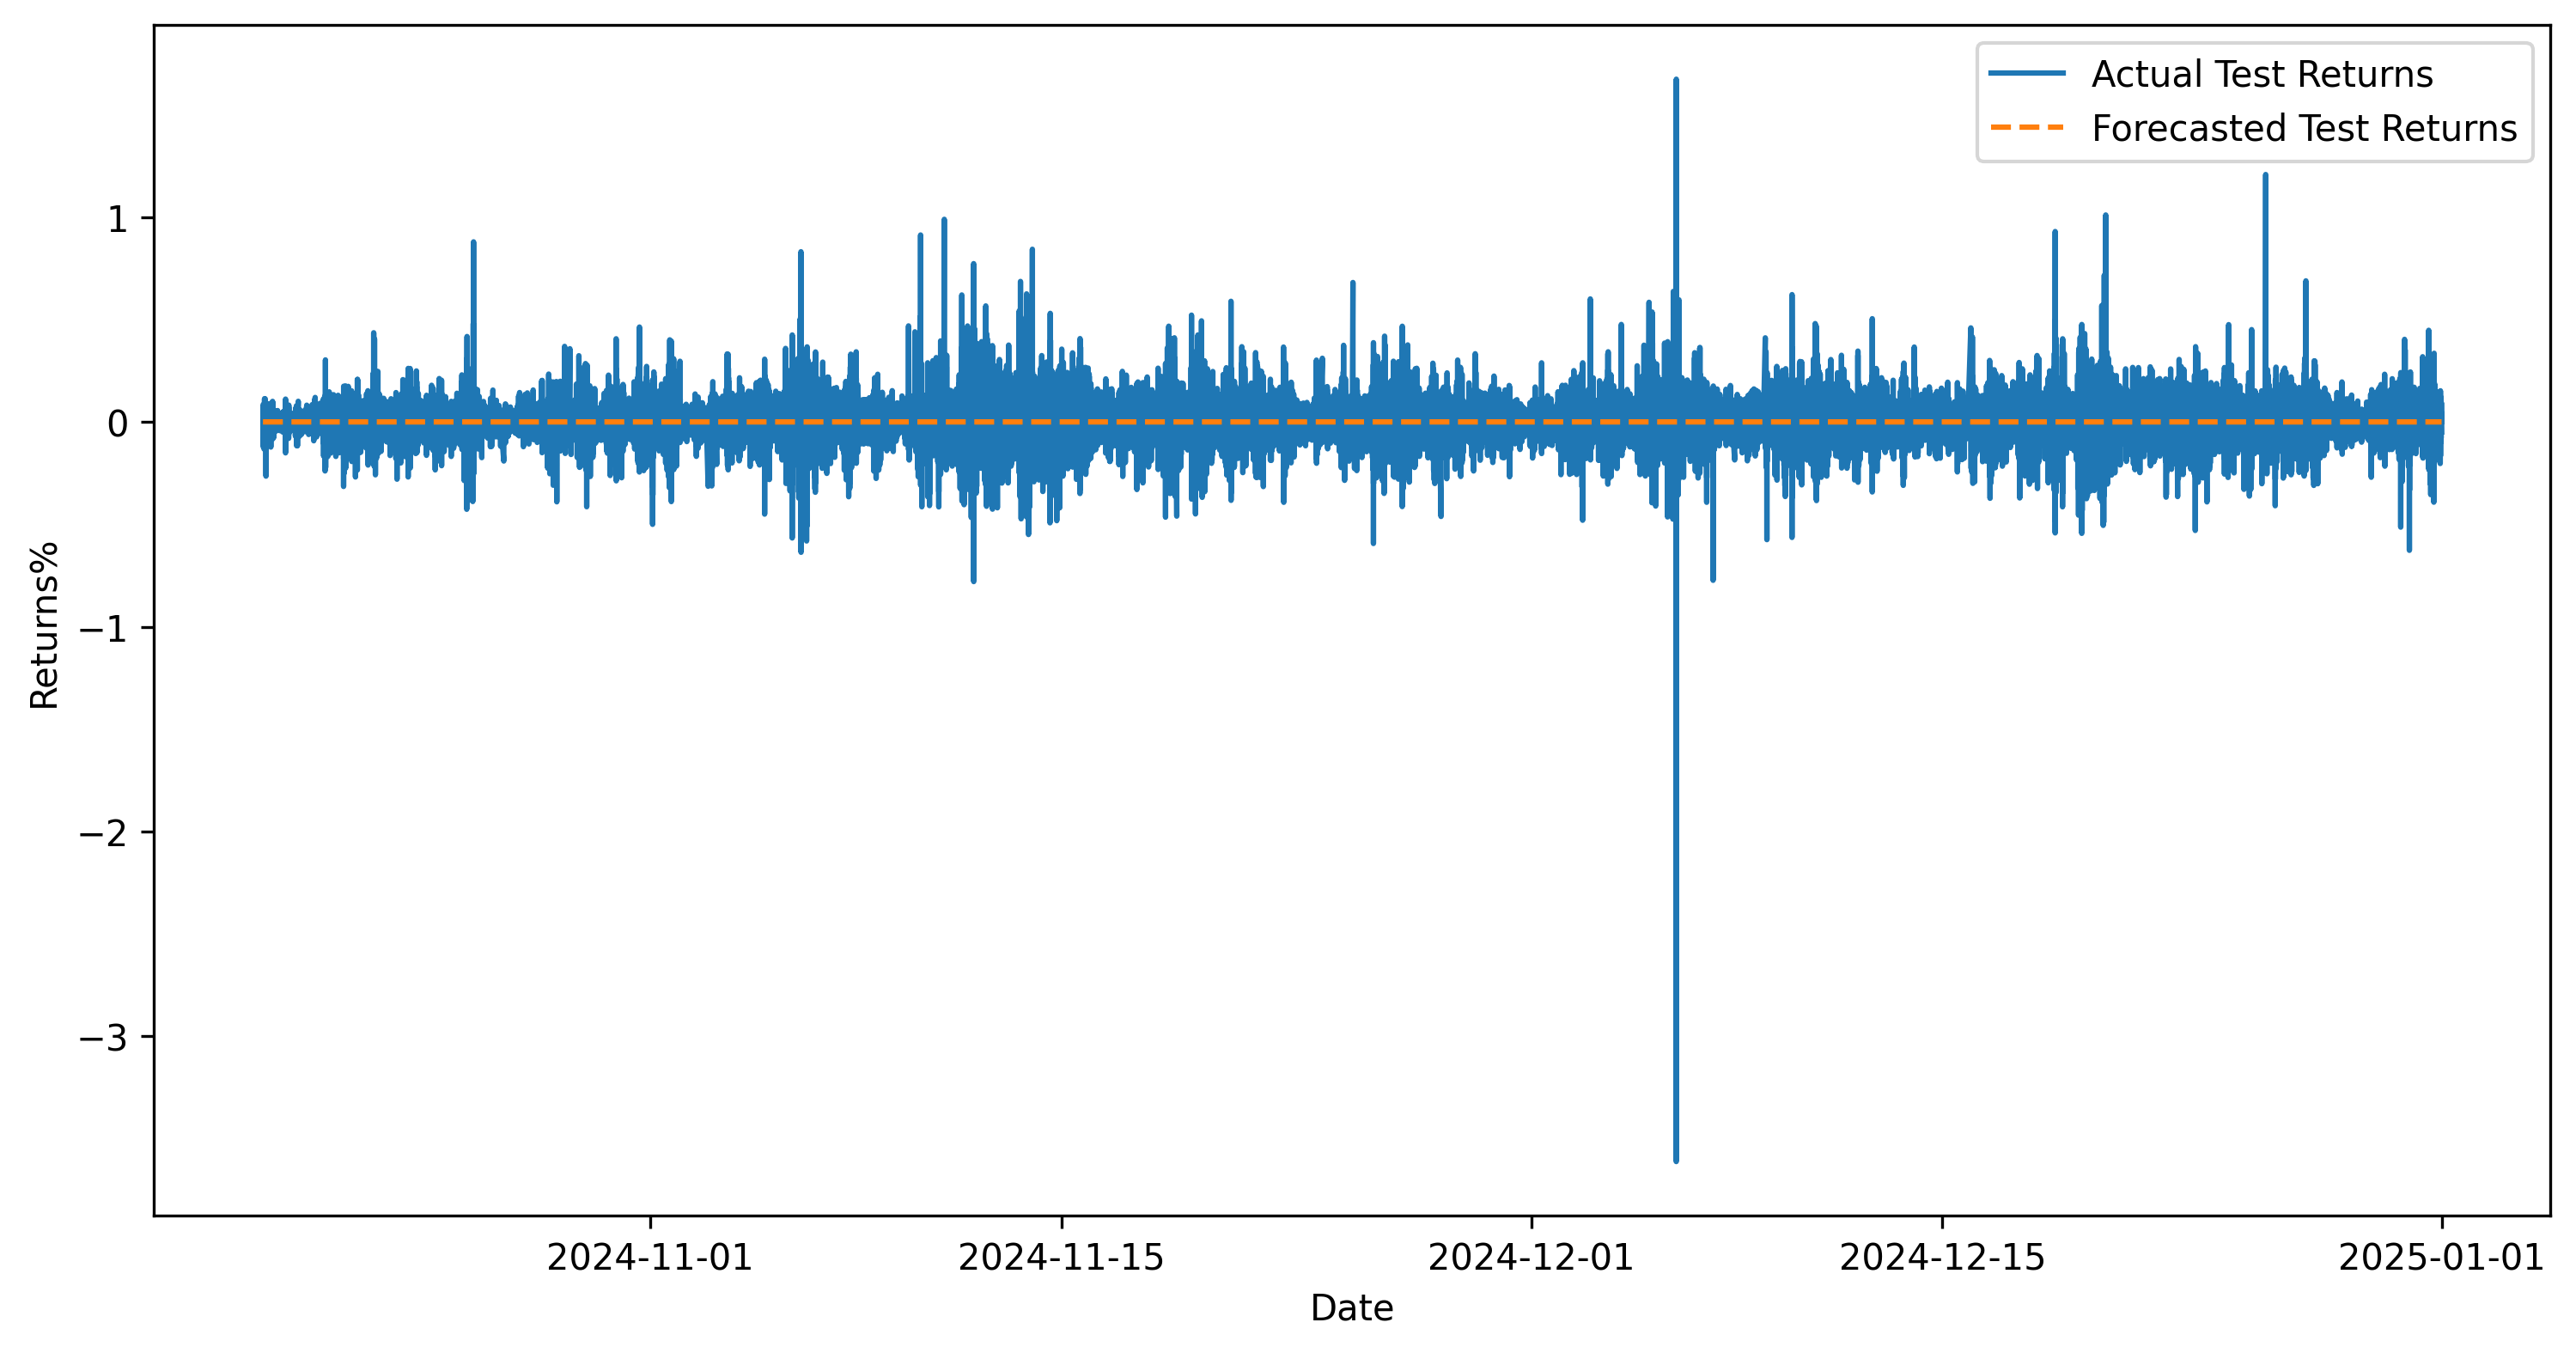

In [13]:
# Plot actual vs forecasted returns for the test set
plt.plot(test_returns.index, test_returns, label='Actual Test Returns')
plt.plot(test_returns.index, forecast_test, label='Forecasted Test Returns', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Returns%')
# plt.title('ARIMA Forecast vs Actual Returns (Test Set)')

# Show only a few major ticks with full date format
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))  # Adjust the number of shown ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Full date format

plt.legend()
# plt.grid(True)
plt.show()

### Robustness Checks - against the Naïve Mean

In [14]:
# Calculate mean from the training set for validation forecast
mean_train = train_returns.mean()
benchmark_forecast_val = np.full(shape=len(val_returns), fill_value=mean_train)

print("Mean Benchmark Forecast Performance (Validation):")
evaluate_forecast(val_returns, benchmark_forecast_val, label="Benchmark - Validation")

# For the test set, use the combined training and validation data
mean_combined = combined_train_val.mean()
benchmark_forecast_test = np.full(shape=len(test_returns), fill_value=mean_combined)

print("\nMean Benchmark Forecast Performance (Test):")
evaluate_forecast(test_returns, benchmark_forecast_test, label="Benchmark - Test")

Mean Benchmark Forecast Performance (Validation):
Benchmark - Validation MAE: 0.0424
Benchmark - Validation RMSE: 0.0680

Mean Benchmark Forecast Performance (Test):
Benchmark - Test MAE: 0.0468
Benchmark - Test RMSE: 0.0731
